## Download MNIST

In [1]:
!pip install -q torchvision matplotlib tqdm

In [18]:
from torchvision import datasets
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [64]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=False, transform=transform)

train_batchsize, test_batchsize = 128, 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batchsize,
    shuffle=True,
    drop_last=True,
)
test_dataloader  = DataLoader(
    test_dataset,
    batch_size=test_batchsize,
    shuffle=False,
)

In [66]:
from tqdm import tqdm
import torch
from IPython.display import clear_output
import numpy as np


def compute_loss(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true)


def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []

    model.train()
    for X, y in tqdm(train_dataloader, leave=False, desc='Train epoch'):
        X, y = X.to(device), y.to(device)

        output = model(X)
        loss = compute_loss(output, y)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        optimizer.zero_grad()

        pred = torch.max(output, 1).indices
        acc = (pred == y).sum() / y.shape[0]
        acc_log.append(acc.item())

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log


@torch.inference_mode()
def test(model):
    loss_log, acc_log = [], []

    model.eval()
    for x_batch, y_batch in tqdm(test_dataloader, leave=False, desc='Test'):
        output = model(x_batch.to(device)).cpu()
        loss = compute_loss(output, y_batch)

        # compute gradients
        loss = loss.item()
        loss_log.append(loss)

        pred = torch.max(output, 1).indices
        acc = (pred == y_batch).sum() / y_batch.shape[0]
        acc_log.append(acc.item())

    return loss_log, acc_log


def plot_history(train_history, test_history, epoch, title='loss'):
    plt.figure()

    plt.title('{} at {} epoch'.format(title, epoch + 1))
    plt.plot(train_history, label='train', zorder=1)

    points = torch.tensor(test_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='test', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()


def train_loop(model, opt, scheduler, epochs=10):
    train_log, train_acc_log = [],[]
    test_log, test_acc_log = [],[]

    steps = len(train_dataset) / train_batchsize
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, opt)
        test_loss, test_acc = test(model)
        scheduler.step(np.mean(train_loss))

        # store metrics
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        test_log.append((steps * (epoch + 1), np.mean(test_loss)))
        test_acc_log.append((steps * (epoch + 1), np.mean(test_acc)))

        # plot all metrics (loss and acc for train/test)
        clear_output()
        plot_history(train_log, test_log, epoch)
        plot_history(train_acc_log, test_acc_log, epoch, title='accuracy')
        print(f'Last accuracy: {test_acc_log[-1][1]}')
    return test_acc_log[-1][1]

In [100]:
class Block(nn.Module):
    def __init__(self, features_in, features_out, dropout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(features_in, features_out),
            nn.GELU(),
            nn.BatchNorm1d(features_out),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.seq(x)


class Net(nn.Module):
    def __init__(self, embed_dim, hidden_size, dropout):
        super().__init__()
        self.seq = nn.Sequential(
            Block(embed_dim, hidden_size, dropout),
            Block(hidden_size, hidden_size * 2, dropout),
            Block(hidden_size * 2, hidden_size * 4, dropout),
            Block(hidden_size * 4, hidden_size * 2, dropout),
            Block(hidden_size * 2, hidden_size, dropout),
        )
        self.clf = nn.Linear(hidden_size, 10)
        print(f"{self._count_parameters()/1e3:.2f}K parameters")

    def _count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, inputs):
        return self.clf(self.seq(inputs))


EMBED_DIM = 784
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
DROPOUT = 0.4

In [101]:
model = Net(EMBED_DIM, HIDDEN_SIZE, DROPOUT).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=2, factor=0.2)

1521.67K parameters


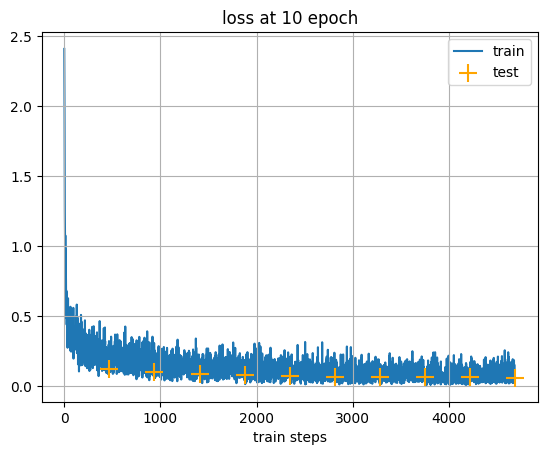

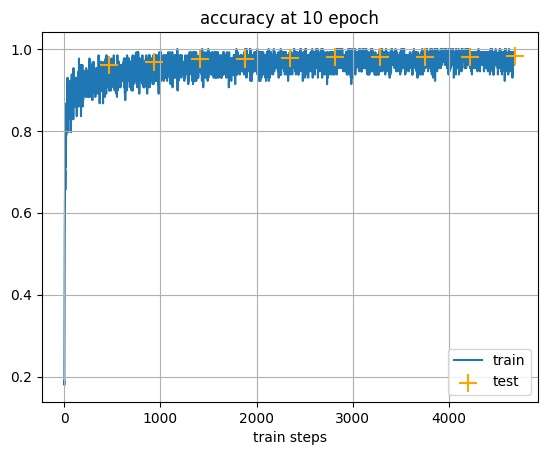

Last accuracy: 0.9834849683544303


In [102]:
last_accuracy = train_loop(model, opt, scheduler)

Last accuracy: 0.9740901898734177<br>
GELU, no dropout, 40 hidden_size: 0.9776503164556962<br>
128 hidden_size, dropout(0.3): 0.9818037974683544<br>
256 hiddeen_size: 0.9831882911392406<br>
Last accuracy: 0.9834849683544303



In [4]:
def cache(fuc):
    cache_dict = {}
    
    def wrapper(*args, **kwargs):
        key = str(args) + str(kwargs)
        
        if key in cache_dict:
            return cache_dict[key]
        else:
            res = fuc(*args, **kwargs)
            cache_dict[key] = res
            return res
    return wrapper


@cache
def fib(n):
    if n < 2:
        return n
    return fib(n - 1) + fib(n - 2)

fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875